# There we can restore model from a checkpoint and show some of the molecules generated by the model!




In [31]:
import pennylane as qml
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import pandas as pd
import argparse
import os
import math
import datetime
import time
from frechetdist import frdist

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch

from solver import Solver
from data_loader import get_loader
from torch.backends import cudnn
from utils import *
from models import Generator, Discriminator
from data.sparse_molecular_dataset import SparseMolecularDataset
from rdkit import Chem

### This is a configuration cell where you need to choose your parameters.

Be aware that not every model can give you a valid molecules, try to use iterations listed in lowest_indices_{model}.csv

In [32]:
def str2bool(v):
    return v.lower() in ('true')

# I suppose everything there is clear

qubits = 5
layer = 2
complexity = 'nr' # Choose from 'hr', 'mr', 'nr'
circuit = 'v2' # Choose from models
models = ['main', 'gen', 'v1', 'v2', 'v3']

num_iters = 5000

# My way of creating different circuits, definitely not great, but this works
if circuit == 'main':
    dev = qml.device('default.qubit', wires=qubits)

    @qml.qnode(dev, interface='torch')
    def gen_circuit(w):
        # random noise as generator input
        z1 = random.uniform(-1, 1)
        z2 = random.uniform(-1, 1)

        # construct generator circuit for both atom vector and node matrix
        for i in range(qubits):
            qml.RY(np.arcsin(z1), wires=i)
            qml.RZ(np.arcsin(z2), wires=i)
        for l in range(layer):
            for i in range(qubits):
                qml.RY(w[i], wires=i)

            for i in range(qubits - 1):
                qml.CNOT(wires=[i, i + 1])
                qml.RZ(w[i + qubits], wires=i + 1)
                qml.CNOT(wires=[i, i + 1])
        return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

elif circuit == 'gen':
    dev = qml.device('default.qubit', wires=qubits)

    @qml.qnode(dev, interface='torch')
    def gen_circuit(w):
        # construct generator circuit for both atom vector and node matrix
        for i in range(qubits):
            # random noise as generator input
            z1 = random.uniform(-1, 1)
            z2 = random.uniform(-1, 1)
            qml.RY(np.arcsin(z1), wires=i)
            qml.RZ(np.arcsin(z2), wires=i)

        for l in range(layer):
            for i in range(qubits):
                qml.RY(w[i], wires=i)
            for i in range(qubits - 1):
                qml.CNOT(wires=[i, i + 1])
                qml.RZ(w[i + qubits], wires=i + 1)
                qml.CNOT(wires=[i, i + 1])

        return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

elif circuit == 'v1':
    dev = qml.device('default.qubit', wires=qubits)

    @qml.qnode(dev, interface='torch')
    def gen_circuit(w):
        # random noise as generator input
        z1 = random.uniform(-1, 1)
        z2 = random.uniform(-1, 1)

        # construct generator circuit for both atom vector and node matrix
        for i in range(qubits):
            qml.RY(np.arcsin(z1), wires=i)
            qml.RZ(np.arcsin(z2), wires=i)

        for l in range(layer):
            for i in range(qubits):
                qml.RY(w[i], wires=i)
            for i in range(qubits - 1):
                qml.RZ(w[i + qubits], wires=i + 1)
                qml.CNOT(wires=[i, i + 1])
            qml.RZ(w[-1], wires=qubits - 1)

        return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

elif circuit == 'v2':
    dev = qml.device('default.qubit', wires=qubits)


    @qml.qnode(dev, interface='torch')
    def gen_circuit(w):
        # random noise as generator input
        z1 = random.uniform(-1, 1)
        z2 = random.uniform(-1, 1)

        # construct generator circuit for both atom vector and node matrix
        for i in range(qubits):
            qml.RY(np.arcsin(z1), wires=i)
            qml.RZ(np.arcsin(z2), wires=i)

        for l in range(layer):
            for i in range(qubits):
                qml.RY(w[i], wires=i)
            for i in range(qubits - 1):
                qml.CNOT(wires=[i, i + 1])
                qml.RZ(w[i + qubits], wires=i + 1)
            qml.RZ(w[-1], wires=qubits - 1)
            for i in range(qubits - 1):
                qml.CNOT(wires=[qubits - 1 - i, qubits - 2 - i])

        return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

elif circuit == 'v3':
    dev = qml.device('default.qubit', wires=qubits)


    @qml.qnode(dev, interface='torch')
    def gen_circuit(w):
        # random noise as generator input
        z1 = random.uniform(-1, 1)
        z2 = random.uniform(-1, 1)

        # construct generator circuit for both atom vector and node matrix
        for i in range(qubits):
            qml.RY(np.arcsin(z1), wires=i)
            qml.RZ(np.arcsin(z2), wires=i)

        for l in range(layer):
            for i in range(qubits):
                qml.RY(w[i], wires=i)
            for i in range(qubits - 1):
                qml.CNOT(wires=[i, i + 1])
                qml.RZ(w[i + qubits], wires=i + 1)
                qml.CNOT(wires=[i, i + 1])
                if i != 0:
                    qml.Toffoli(wires=[i + 1, i, i - 1])

        return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [33]:
# If you need to change something specific, then change it there/add variables, do not limit yourself
parser = argparse.ArgumentParser()

# Quantum circuit configuration
parser.add_argument('--quantum', type=bool, default=True, help='choose to use quantum gan with hybrid generator')
parser.add_argument('--patches', type=int, default=1, help='number of quantum circuit patches')
parser.add_argument('--layer', type=int, default=layer, help='number of repeated variational quantum layer')
parser.add_argument('--qubits', type=int, default=qubits, help='number of qubits and dimension of domain labels')

# Model configuration.
parser.add_argument('--z_dim', type=int, default=qubits, help='dimension of domain labels')

parser.add_argument('--g_conv_dim', help='number of conv filters in the first layer of G')

parser.add_argument('--d_conv_dim', type=int, default=[[128, 64], 128, [128, 64]],
                    help='number of conv filters in the first layer of D')
parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')
parser.add_argument('--post_method', type=str, default='softmax', choices=['softmax', 'soft_gumbel', 'hard_gumbel'])

# Training configuration.
parser.add_argument('--batch_size', type=int, default=16, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=num_iters, help='number of total iterations for training D')
parser.add_argument('--num_iters_decay', type=int, default=2500, help='number of iterations for decaying lr')
parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
parser.add_argument('--dropout', type=float, default=0., help='dropout rate')
parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')

# Test configuration.
parser.add_argument('--test_iters', type=int, default=5000, help='test model from this step')

# Miscellaneous.
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--mode', type=str, default='train', choices=['train', 'test'])
parser.add_argument('--use_tensorboard', type=str2bool, default=False)

# Directories.
parser.add_argument('--mol_data_dir', type=str, default='data/gdb9_9nodes.sparsedataset')
parser.add_argument('--log_dir', type=str, default='qgan-{}-{}-q{}-l{}/logs'.format(circuit, complexity, qubits, layer))
parser.add_argument('--model_save_dir', type=str, default='qgan-{}-{}-q{}-l{}/models'.format(circuit, complexity, qubits, layer))
parser.add_argument('--sample_dir', type=str, default='qgan-{}-{}-q{}-l{}/samples'.format(circuit, complexity, qubits, layer))
parser.add_argument('--result_dir', type=str, default='qgan-{}-{}-q{}-l{}/results'.format(circuit, complexity, qubits, layer))

# Step size.
parser.add_argument('--log_step', type=int, default=10)
parser.add_argument('--sample_step', type=int, default=1000)
parser.add_argument('--model_save_step', type=int, default=1000)
parser.add_argument('--lr_update_step', type=int, default=500)

# Quantum circuits.
parser.add_argument('--circuit', type=str, default='main', choices=models)

config = parser.parse_known_args()[0]
if complexity == 'nr':
    config.g_conv_dim = [128, 256, 512]
elif complexity == 'mr':
    config.g_conv_dim = [128]
elif complexity == 'hr':
    config.g_conv_dim = [16]
else:
    raise ValueError("Please enter an valid model complexity from 'mr', 'hr' or 'nr'!")
print(config)

Namespace(batch_size=16, beta1=0.5, beta2=0.999, circuit='main', d_conv_dim=[[128, 64], 128, [128, 64]], d_lr=0.0001, d_repeat_num=6, dropout=0.0, g_conv_dim=[128, 256, 512], g_lr=0.0001, g_repeat_num=6, lambda_cls=1, lambda_gp=10, lambda_rec=10, layer=2, log_dir='qgan-v2-nr-q5-l2/logs', log_step=10, lr_update_step=500, mode='train', model_save_dir='qgan-v2-nr-q5-l2/models', model_save_step=1000, mol_data_dir='data/gdb9_9nodes.sparsedataset', n_critic=5, num_iters=5000, num_iters_decay=2500, num_workers=1, patches=1, post_method='softmax', quantum=True, qubits=5, result_dir='qgan-v2-nr-q5-l2/results', resume_iters=None, sample_dir='qgan-v2-nr-q5-l2/samples', sample_step=1000, test_iters=5000, use_tensorboard=False, z_dim=5)


In [34]:
# Creating solver from config
solver = Solver(config)

# This one is just for convenience, and to double-check yourself
'qgan-{}-{}-q{}-l{}/models/quantum_weights_'.format(circuit, complexity, qubits, layer) + circuit+ '.csv'

Generator(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.0, inplace=True)
  )
  (edges_layer): Linear(in_features=512, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=512, out_features=45, bias=True)
  (dropoout): Dropout(p=0.0, inplace=False)
)
G
The number of parameters: 396226
Discriminator(
  (gcn_layer): GraphConvolution(
    (linear1): Linear(in_features=5, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (agg_layer): GraphAggregation(
    (sigmoid_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Sigmoid()
    )
    (tan

'qgan-v2-nr-q5-l2/models/quantum_weights_v2.csv'

In [35]:
# Inference of generated molecules
quantum_weights = pd.read_csv('qgan-{}-{}-q{}-l{}/models/quantum_weights_'.format(circuit, complexity, qubits, layer) + circuit + '.csv', header=None)

solver.resume_iters = 3205

# quantum_iters = solver.resume_iters

# I've added writing quantum weights together with model checkpoint later in development,
# so for my demo I'll be using the closest weights to the model (4995 -> 4990, and so on)
quantum_iters = math.floor(solver.resume_iters/10) * 10

if solver.resume_iters:
    # Restore model
    solver.restore_model(solver.resume_iters)

    # Retract quantum weights from file
    gen_weights = torch.tensor(quantum_weights[quantum_weights[0] == quantum_iters].iloc[0, 1:].tolist(), requires_grad=True)

ibm_sample_list = []
for i in range(solver.batch_size):
    ibm_sample_list.append(gen_circuit(gen_weights))

Loading the trained models from step 3205...


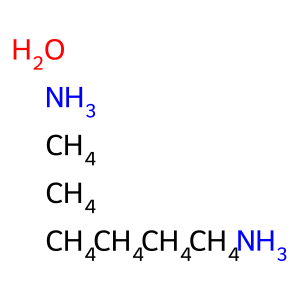

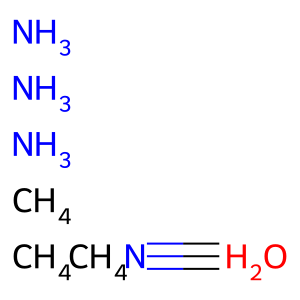

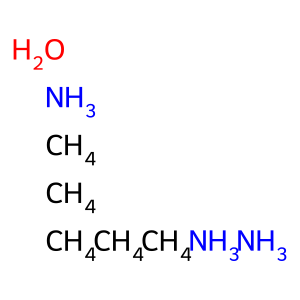

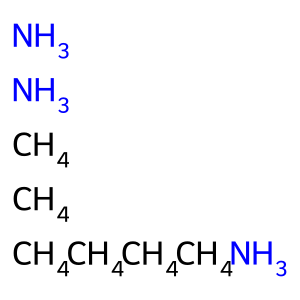

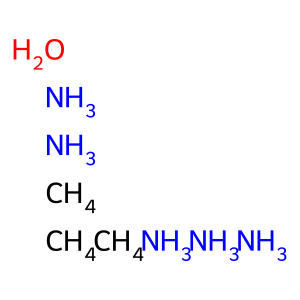

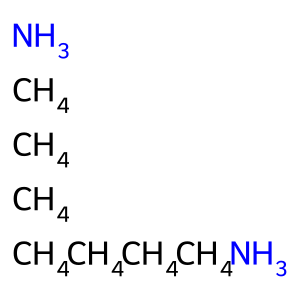

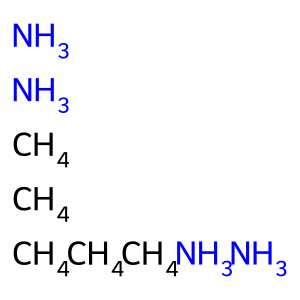

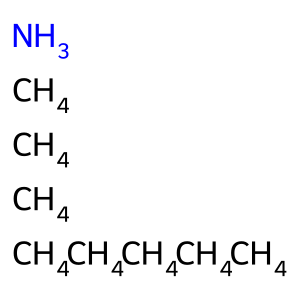

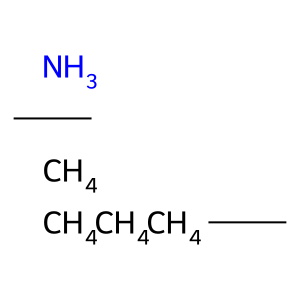

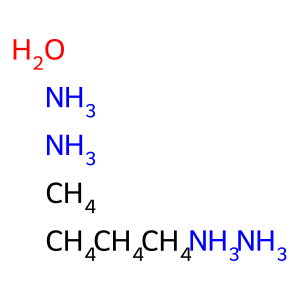

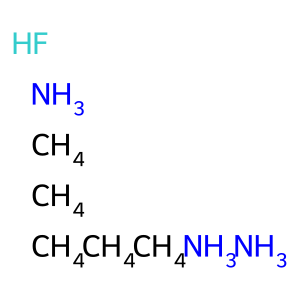

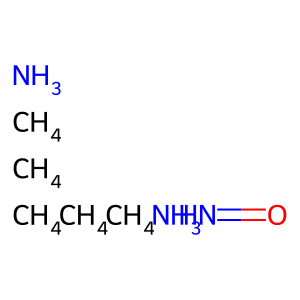

1


In [43]:
# Start inference.
loss = {'unique score': 0}
step = 0

# I encountered problems while creating molecules, because not every model gives a working one, that is valid,
# so I've decided to give every model 10 tries
while loss['unique score'] == 0 and step < 10:
    start_time = time.time()

    mols, _, _, a, x, _, _, _, _ = solver.data.next_train_batch(solver.batch_size)

    # =================================================================================== #
    #                             1. Preprocess input data                                #
    # =================================================================================== #

    a = torch.from_numpy(a).to(solver.device).long()            # Adjacency.
    x = torch.from_numpy(x).to(solver.device).long()            # Nodes.
    a_tensor = solver.label2onehot(a, solver.b_dim)
    x_tensor = solver.label2onehot(x, solver.m_dim)
    z = torch.stack(tuple(ibm_sample_list)).to(solver.device).float()

    # Z-to-target
    edges_logits, nodes_logits = solver.G(z)
    # Postprocess with Gumbel softmax
    (edges_hat, nodes_hat) = solver.postprocess((edges_logits, nodes_logits), solver.post_method)
    logits_fake, features_fake = solver.D(edges_hat, None, nodes_hat)
    g_loss_fake = - torch.mean(logits_fake)

    # Real Reward
    rewardR = torch.from_numpy(solver.reward(mols)).to(solver.device)
    # Fake Reward
    (edges_hard, nodes_hard) = solver.postprocess((edges_logits, nodes_logits), 'hard_gumbel')
    edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
    mols = [solver.data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
            for e_, n_ in zip(edges_hard, nodes_hard)]
    rewardF = torch.from_numpy(solver.reward(mols)).to(solver.device)

    # Value loss
    value_logit_real,_ = solver.V(a_tensor, None, x_tensor, torch.sigmoid)
    value_logit_fake,_ = solver.V(edges_hat, None, nodes_hat, torch.sigmoid)
    g_loss_value = torch.mean((value_logit_real - rewardR) ** 2 + (
                               value_logit_fake - rewardF) ** 2)

    R=[list(a[i].reshape(-1))  for i in range(solver.batch_size)]
    F=[list(edges_hard[i].reshape(-1))  for i in range(solver.batch_size)]
    fd_bond_only = frdist(R, F)

    R=[list(x[i]) + list(a[i].reshape(-1))  for i in range(solver.batch_size)]
    F=[list(nodes_hard[i]) + list(edges_hard[i].reshape(-1))  for i in range(solver.batch_size)]
    fd_bond_atom = frdist(R, F)

    loss = {}
    loss['G/loss_fake'] = g_loss_fake.item()
    loss['G/loss_value'] = g_loss_value.item()
    loss['FD/fd_bond_only'] = fd_bond_only
    loss['FD/fd_bond_atom'] = fd_bond_atom

    et = time.time() - start_time
    et = str(datetime.timedelta(seconds=et))[:-7]
    log = "Elapsed [{}], Iteration [{}/{}]".format(et, solver.resume_iters, solver.num_iters)

    # Log update
    m0, m1 = all_scores(mols, solver.data, norm=True)     # 'mols' is output of Fake Reward
    m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
    m0.update(m1)
    loss.update(m0)
    for tag, value in loss.items():
        log += ", {}: {:.4f}".format(tag, value)

    # Uncomment if you want to se log info of interference attempt
    # print(log)

    # Keep only valid moleculues evaluated by RDKit
    valid_mols = [i for i in mols if i is not None]

    from rdkit.Chem.Draw import SimilarityMaps
    import matplotlib

    # Select not duplicate molecules
    # Convert molecules to a list of string representations
    molecule_strings = [Chem.MolToSmiles(mol) for mol in valid_mols]

    # Create a set to remove duplicates
    unique_molecules = set(molecule_strings)

    # Convert back to RDKit molecules
    unique_molecules_list = [Chem.MolFromSmiles(smiles) for smiles in unique_molecules]

    for mol in unique_molecules_list:
        # Uncomment to draw similarity maps
        # AllChem.ComputeGasteigerCharges(mol)
        # contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
        # fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap=None,  contourLines=10)

        # Comment to not draw just molecules
        img = Draw.MolToImage(mol)
        display(img)
    step += 1
    print(step)

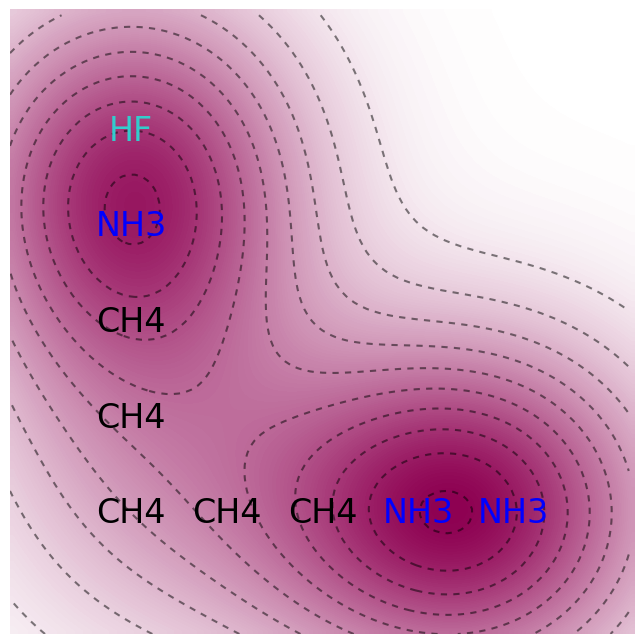

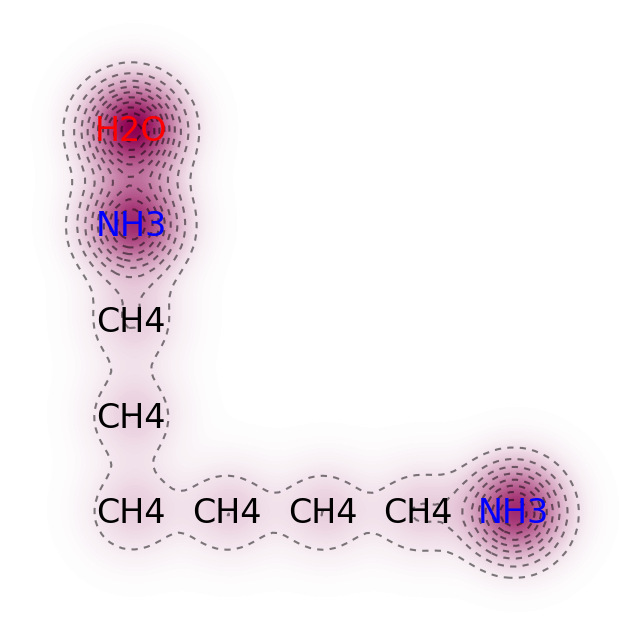

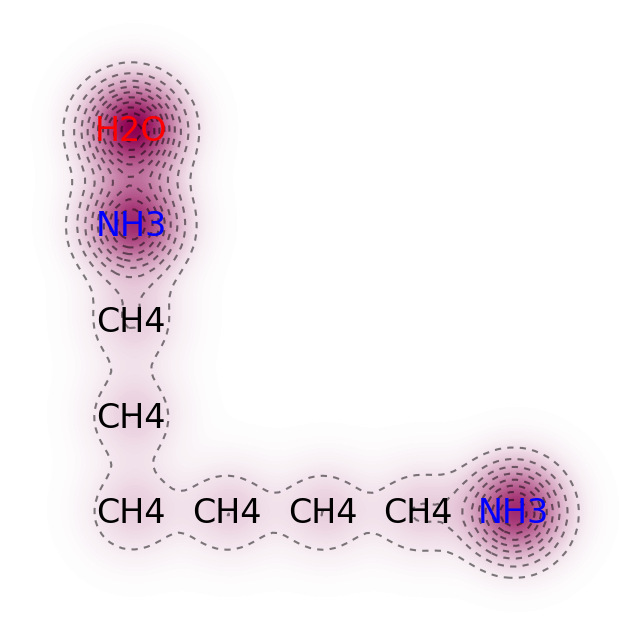

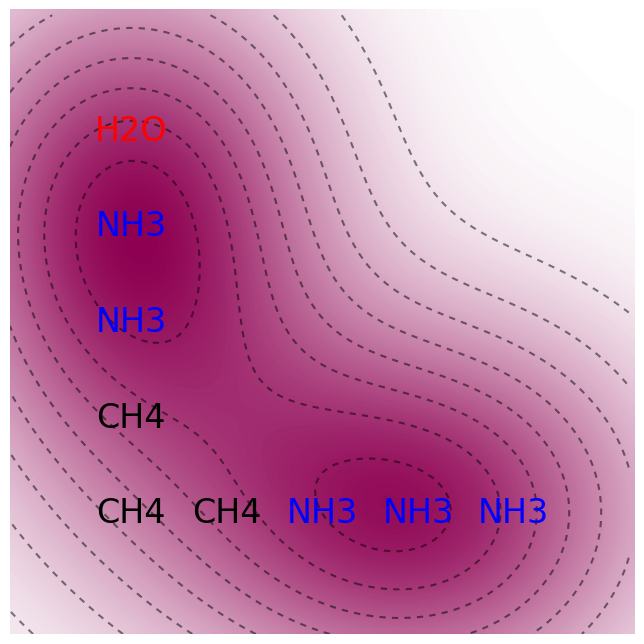

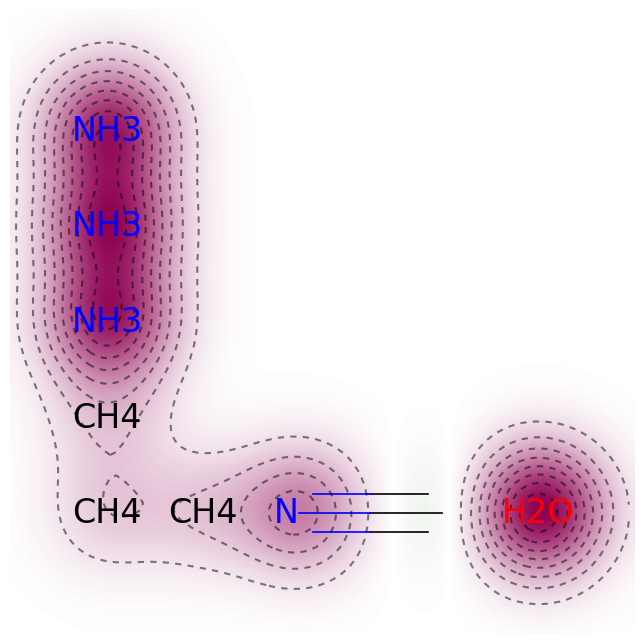

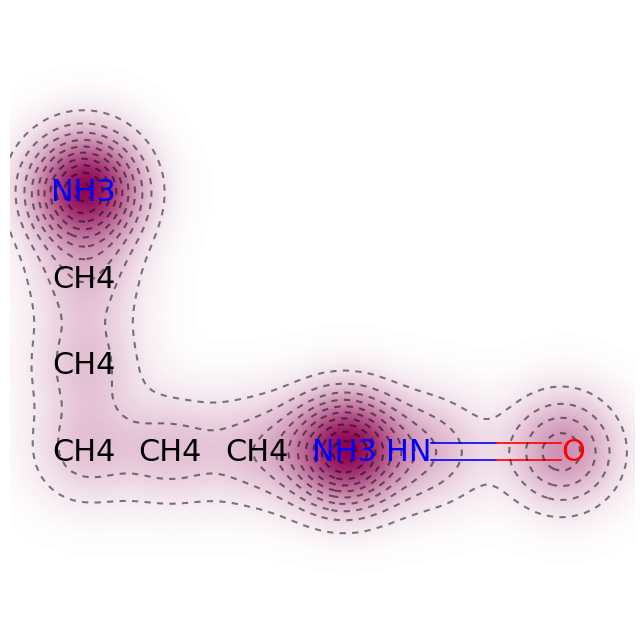

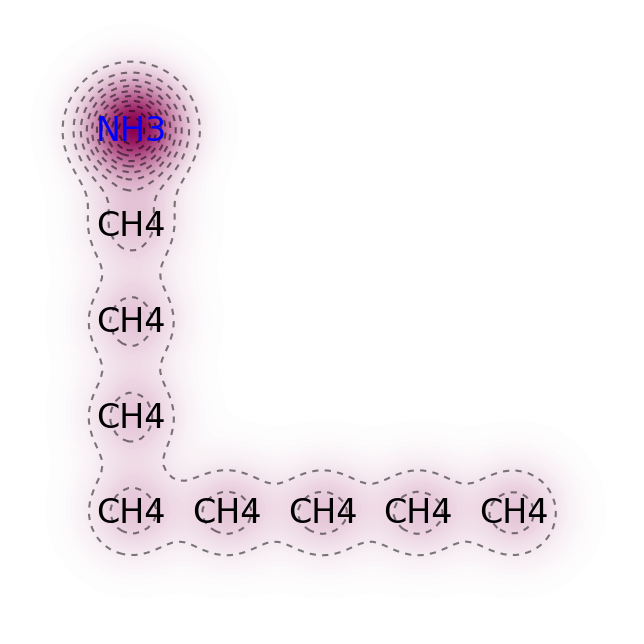

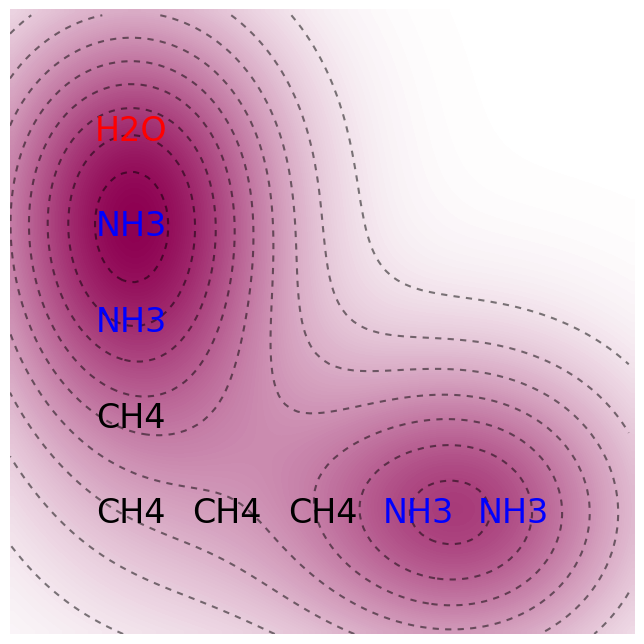

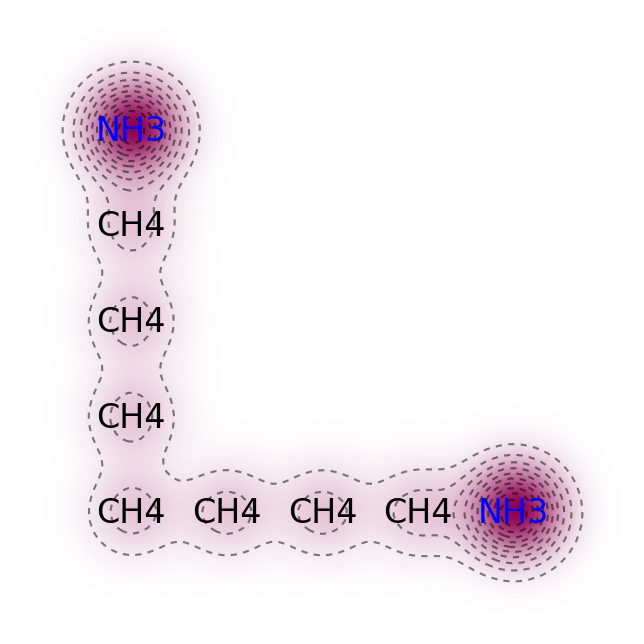

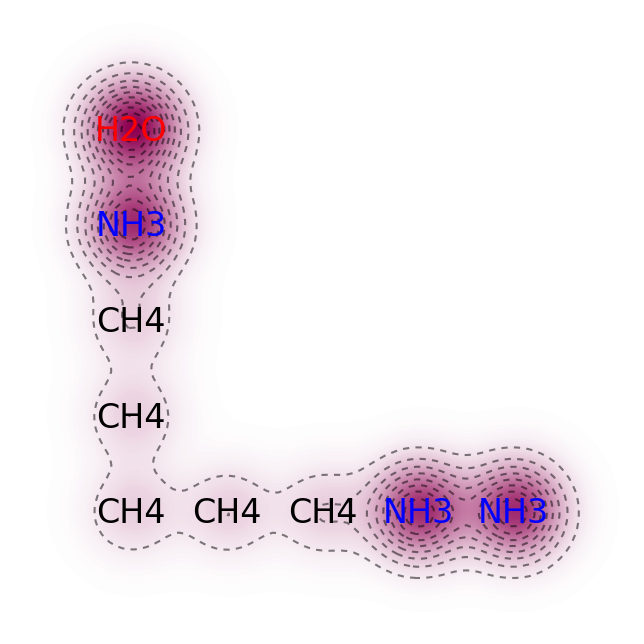

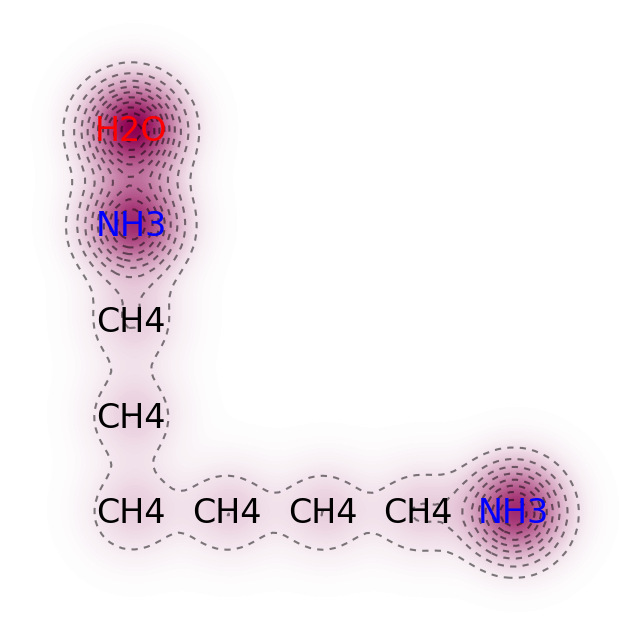

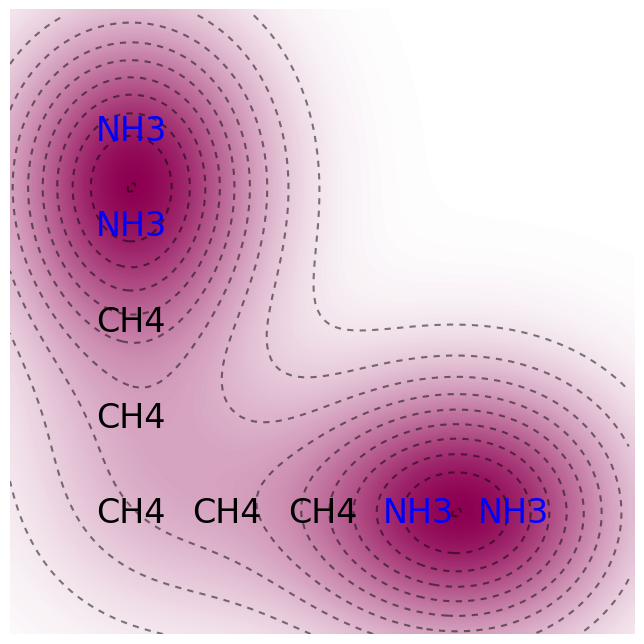

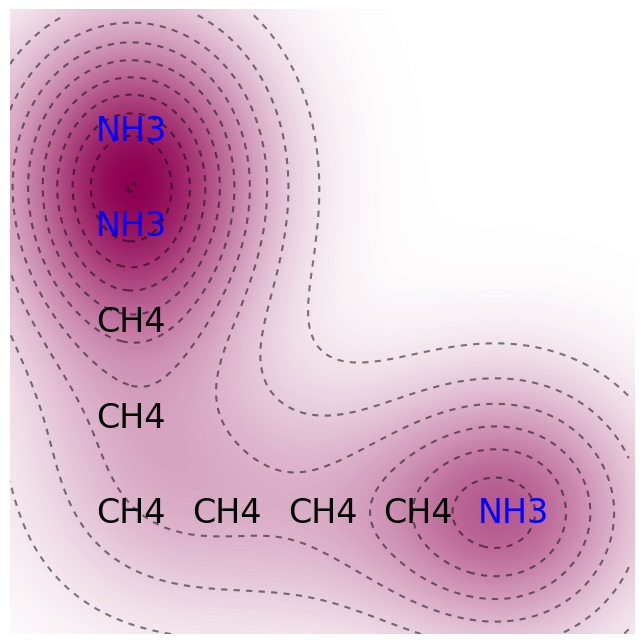

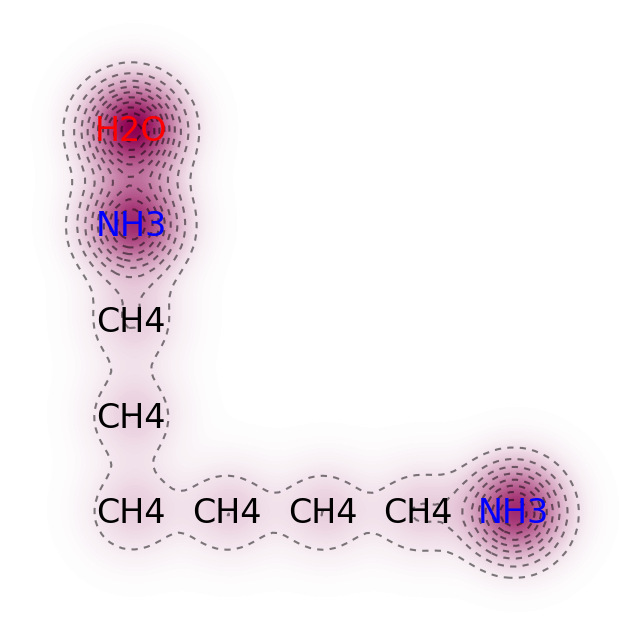

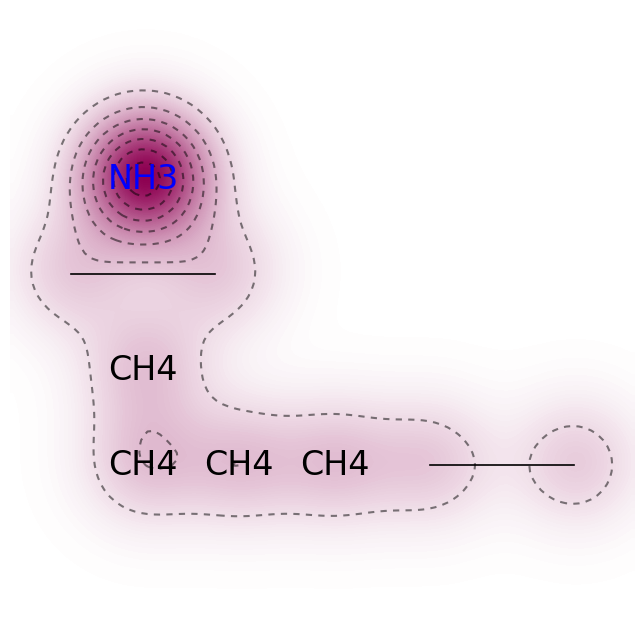

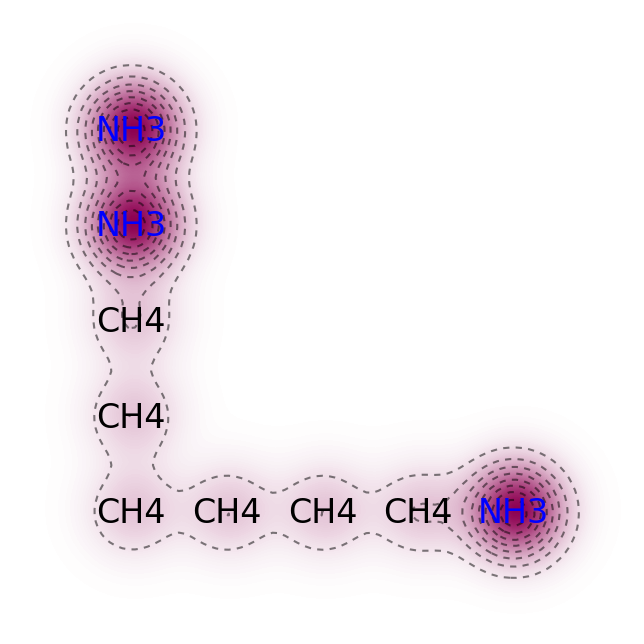

In [44]:
for mol in unique_molecules_list:
    AllChem.ComputeGasteigerCharges(mol)
    contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap=None,  contourLines=10)

    # img = Draw.MolToImage(mol)
    # display(img)